In this part, the data from GSE55763 will be imported, quality-checked, and structured to facilitate downstream analysis.

In [12]:
import GEOparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [19]:
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

In [20]:
gse = GEOparse.get_GEO(geo="GSE55763", destdir="./data", silent=True, how="full")

In [24]:
print(list(gse.gsms.keys())[:3])

['GSM1343050', 'GSM1343051', 'GSM1343052']


In this case, GSM1343050, GSM1343051, GSM1343052 are sample IDs.

Explore the metadata in GSE55763

In [33]:
metadata = {}
for gsm_name, gsm in gse.gsms.items():
    for key, value in gsm.metadata.items():
        if key == 'characteristics_ch1':
            tmpVal = 0
            for tmp in value:
                splitUp = [i.strip() for i in tmp.split(':')]
                if len(splitUp) == 2:
                    if not splitUp[0] in metadata:
                        metadata[splitUp[0]] = {}
                    metadata[splitUp[0]][gsm_name] = splitUp[1]


In [36]:
df_metadata = pd.DataFrame(metadata)

In [40]:
print(df_metadata.head(2))

                      tissue                                        dataset  \
GSM1343050  peripheral blood  population study; technical replication study   
GSM1343051  peripheral blood  population study; technical replication study   

           gender   age  
GSM1343050      M  57.9  
GSM1343051      M    42  


In [42]:
print(df_metadata.tail(2))

                      tissue           dataset gender   age
GSM1345759  peripheral blood  population study      M  39.5
GSM1345760  peripheral blood  population study      F  52.5


In [ ]:
df_metadata = df_metadata.transpose() ## Transpose the DataFrame so that samples are rows and metadata fields are columns

In [46]:
print(df_metadata.head(3))   # display the first 3 rows

                      tissue                                        dataset  \
GSM1343050  peripheral blood  population study; technical replication study   
GSM1343051  peripheral blood  population study; technical replication study   
GSM1343052  peripheral blood  population study; technical replication study   

           gender   age  
GSM1343050      M  57.9  
GSM1343051      M    42  
GSM1343052      M  47.4  


In [49]:
print(df_metadata.columns) 

Index(['tissue', 'dataset', 'gender', 'age'], dtype='object')


In [54]:
# Keep only samples with age and gender
df_filtered = df_metadata.dropna(subset=['age', 'gender'])

# Filter human samples based on tissue keywords
human_keywords = ['human', 'Homo sapiens', 'blood', 'peripheral blood', 'PBMC', 'whole blood']
mask_human = df_filtered['tissue'].str.contains('|'.join(human_keywords), case=False, na=False)
df_filtered = df_filtered[mask_human]

# Keep population study samples; include technical replicates only if part of population study
mask_population = ~df_filtered['dataset'].str.contains('technical replication', case=False, na=False) | \
                  df_filtered['dataset'].str.contains('population study', case=False, na=False)
df_filtered = df_filtered[mask_population]

# Reset index
df_filtered = df_filtered.reset_index(drop=True)

print(f"Number of human samples after filtering: {df_filtered.shape[0]}")


Number of human samples after filtering: 2664


In [59]:
df_filtered['age'] = pd.to_numeric(df_filtered['age'], errors='coerce') # convert to numeric for further analysis
print(df_filtered['age'].describe().round(2)) # Summary statistics and round to 2 digits

count    2664.00
mean       50.95
std        10.08
min        23.70
25%        43.20
50%        50.10
75%        57.50
max        75.00
Name: age, dtype: float64


In [62]:
print("Median age:", df_filtered['age'].median()) # Calculate the median
print("Mode age:", df_filtered['age'].mode().to_list()) #Calculate a mode and store its a list

Median age: 50.1
Mode age: [35.1, 35.2]


Outliers Analysis

In [65]:
# Outlier analysis on filtered samples
age = df_filtered['age'].dropna()

Q1 = np.percentile(age, 25)
Q3 = np.percentile(age, 75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = age[(age < lower) | (age > upper)]
print(f"Lower bound: {lower:.2f}, Upper bound: {upper:.2f}")
print("Outliers:", outliers.values)


Lower bound: 21.75, Upper bound: 78.95
Outliers: []


Data visualization

Age

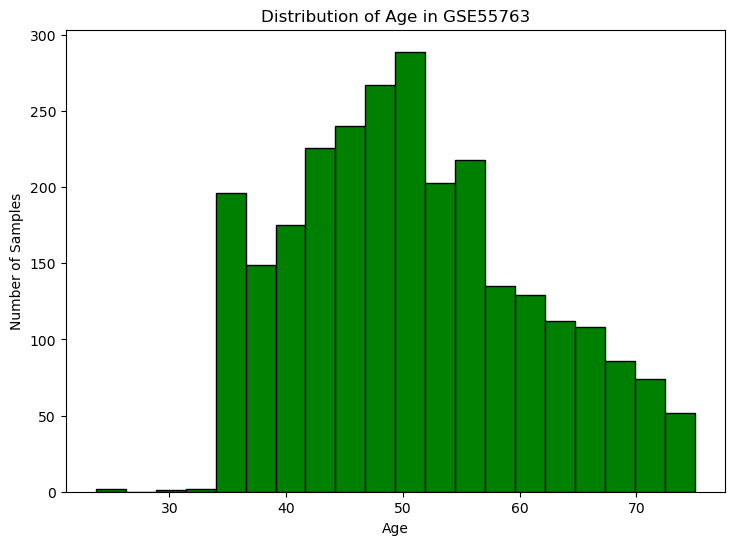

In [70]:
plt.figure(figsize=(8.5, 6))
plt.hist(df_filtered['age'], bins=20, color='green', edgecolor='black')
plt.title('Distribution of Age in GSE55763')
plt.xlabel('Age')
plt.ylabel('Number of Samples')
plt.show()

Another alternative: density plot

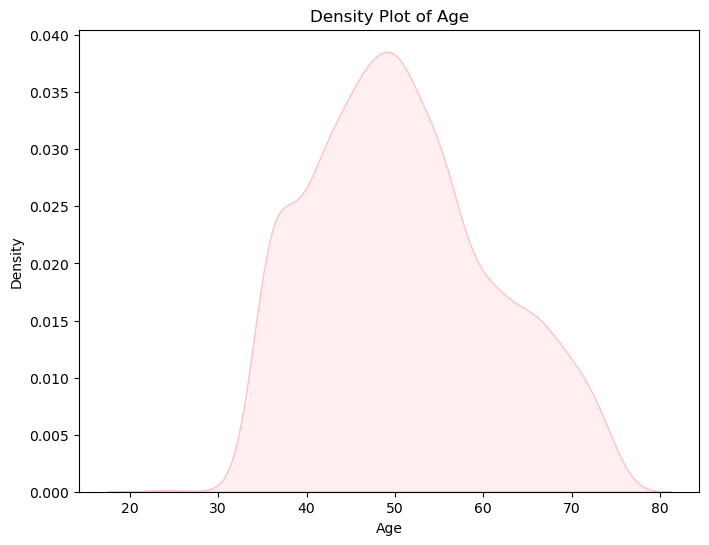

In [72]:
plt.figure(figsize=(8,6))
sns.kdeplot(df_filtered['age'], fill=True, color='pink')
plt.title('Density Plot of Age')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

Gender

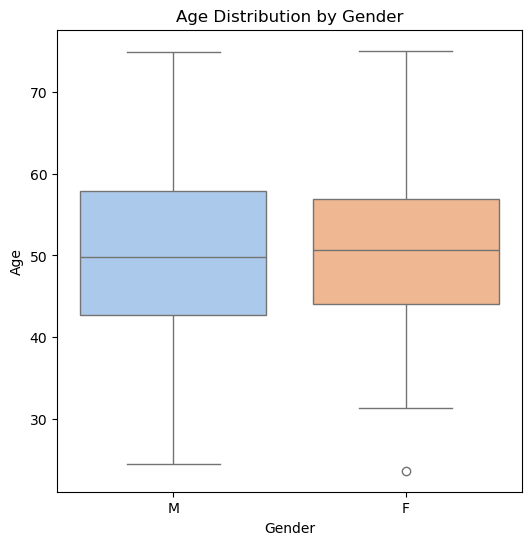

In [83]:
plt.figure(figsize=(6,6))
ax = sns.boxplot(x='gender', y='age', data=df_filtered, palette='pastel', dodge=False, hue='gender')
plt.title("Age Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Age")
plt.show()

Barplot

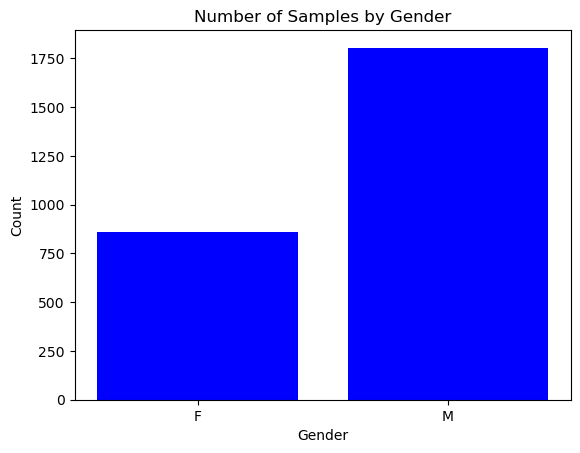

In [91]:
counts = [df_filtered['gender'].value_counts().get('F', 0),
          df_filtered['gender'].value_counts().get('M', 0)]

plt.bar(['F', 'M'], counts, color=['blue'])
plt.title("Number of Samples by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

In [ ]:
Statistics tests

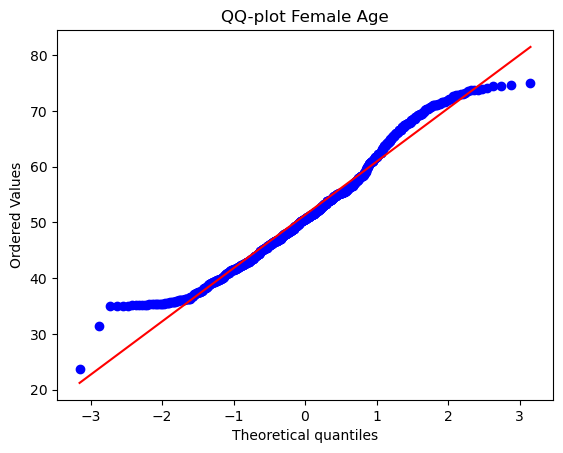

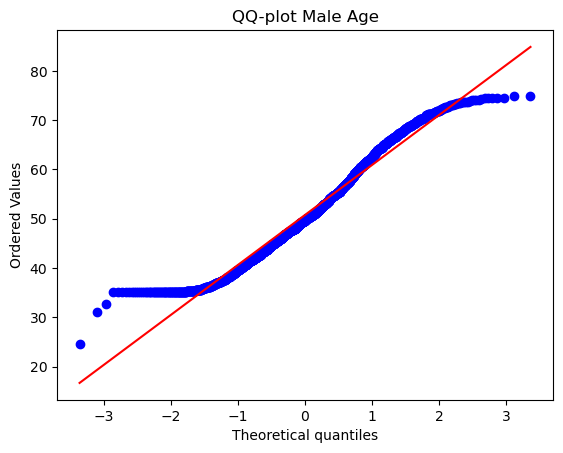

In [97]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(df_filtered[df_filtered['gender']=='F']['age'], dist="norm", plot=plt)
plt.title("QQ-plot Female Age")
plt.show()

stats.probplot(df_filtered[df_filtered['gender']=='M']['age'], dist="norm", plot=plt)
plt.title("QQ-plot Male Age")
plt.show()

In [99]:
from scipy.stats import shapiro

shapiro(df_filtered[df_filtered['gender']=='F']['age'])
shapiro(df_filtered[df_filtered['gender']=='M']['age'])

ShapiroResult(statistic=0.9677763047397993, pvalue=1.1698228777437483e-19)

The Shapiro-Wilk test indicated p < 0.05, suggesting that the age distribution significantly deviates from normality in at least one group. Therefore, a non-parametric test, such as the Mann-Whitney U test, should be used to compare age between males and females.

In [101]:
from scipy.stats import mannwhitneyu

# Separate age by gender
age_f = df_filtered[df_filtered['gender'] == 'F']['age']
age_m = df_filtered[df_filtered['gender'] == 'M']['age']

# Perform Mann-Whitney U test (two-sided)
stat, p_val = mannwhitneyu(age_f, age_m, alternative='two-sided')

print(f"Mann-Whitney U test: U = {stat}, p = {p_val:.3f}")


Mann-Whitney U test: U = 808623.5, p = 0.072


There is no statistically significant difference in age between males and females in this data set GSE55673

Cohort Summary

In [103]:
cohort_summary = pd.DataFrame({
    "Total Samples": [len(df_filtered)],
    "Mean Age": [df_filtered["age"].mean().round(2)],
    "Median Age": [df_filtered["age"].median()],
    "Min Age": [df_filtered["age"].min()],
    "Max Age": [df_filtered["age"].max()],
    "Male Count": [sum(df_filtered["gender"] == "M")],
    "Female Count": [sum(df_filtered["gender"] == "F")]
})

display(cohort_summary)

,Total Samples,Mean Age,Median Age,Min Age,Max Age,Male Count,Female Count
0,2664,50.95,50.1,23.7,75.0,1805,859


In [107]:
gender_table = pd.DataFrame({
    'Count': df_filtered['gender'].value_counts(),
    'Percentage (%)': (df_filtered['gender'].value_counts(normalize=True) * 100).round(2)
})

display(gender_table)

,Count,Percentage (%)
gender,,
M,1805,67.76
F,859,32.24


In [115]:
age_summary = pd.DataFrame({
    "Mean Age": [round(df_filtered["age"].mean(), 2)],
    "Median Age": [df_filtered["age"].median()],
    "Min Age": [df_filtered["age"].min()],
    "Max Age": [df_filtered["age"].max()],
    "Std Dev": [round(df_filtered["age"].std(), 2)],
    "Q1": [df_filtered["age"].quantile(0.25)],
    "Q3": [df_filtered["age"].quantile(0.75)]
})

display(age_summary)

,Mean Age,Median Age,Min Age,Max Age,Std Dev,Q1,Q3
0,50.95,50.1,23.7,75.0,10.08,43.2,57.5
